In [93]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
from utils import u_statistics as u_stats
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats, ndimage
import warnings
from scipy.ndimage.measurements import label
import shapely.geometry as shpg
import datetime
from scipy.stats import gaussian_kde, linregress
import glob
import pickle as pkl

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..


/home/ck/pythonWorkspace/proj_CEH


In [3]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [4]:
corr_all = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT-15_u_correlation_3dRolling_SouthAmerica_1985-2018_diffs.nc')
corr_all = corr_all.assign_coords(dayofyear=corr_all.dayofyear.values)
corr_all = corr_all.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [91]:
def readERA(var):

    u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru_big.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [9]:
era = readERA('u200')
era = era.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).load()

In [10]:
erau = readERA('u550')
erau = erau.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).load()

In [11]:
eraq = readERA('q550')
eraq = eraq.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).load()

In [99]:
erav = readERA('v850')
erav = erav.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).load()

In [94]:
erav5 = readERA('v550')
erav5 = erav5.sel(latitude=slice(-25,0), longitude=slice(-81,-65)).load()

In [12]:
m1=9
m2=4

In [13]:
era_BH_base = era['u'].sel(time=((era['time.year']>=1985)&(era['time.year']<=2018))).load()
era_BH = era_BH_base.groupby('time.month').mean('time')
era_BH_doy = era_BH_base.groupby('time.dayofyear').mean('time')

In [14]:
era_BH_u550_base = erau['u550'].sel(time=((erau['time.year']>=1985)&(erau['time.year']<=2018))).load()
era_BH_u550 = era_BH_u550_base.groupby('time.month').mean('time')
era_BH_doy_u550 = era_BH_u550_base.groupby('time.dayofyear').mean('time')

In [95]:
era_BH_q550_base = eraq['q550'].sel(time=((eraq['time.year']>=1985)&(eraq['time.year']<=2018))).load()
era_BH_q550 = era_BH_q550_base.groupby('time.month').mean('time')
era_BH_doy_q550 = era_BH_q550_base.groupby('time.dayofyear').mean('time')

In [98]:
era_BH_v550_base = erav5['v'].sel(time=((erav5['time.year']>=1985)&(erav5['time.year']<=2018))).load()
era_BH_v550 = era_BH_v550_base.groupby('time.month').mean('time')
era_BH_doy_v550 = era_BH_v550_base.groupby('time.dayofyear').mean('time')

In [100]:
era_BH_v_base = erav['v'].sel(time=((erav['time.year']>=1985)&(erav['time.year']<=2018))).load()
era_BH_v = era_BH_v_base.groupby('time.month').mean('time')
era_BH_doy_v = era_BH_v_base.groupby('time.dayofyear').mean('time')

In [16]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-65), lat=slice(-25,0))
topo_on_g = corr_all.salem.lookup_transform(topo)

In [17]:
ch_on_era = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')
chirps_doypick = ch_on_era['precip'].sel(time=((ch_on_era['time.year']>=1985)&(ch_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))
chirps_bimod = chirps_doypick#.rolling(time=30, min_periods=3, center=True).mean()#.where((chirps_doypick['time.month']!=8))

In [18]:
tir_on_era = xr.open_mfdataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/daily_-15ALLkm2_UTC_DAY_onBIGERA/*.nc',
                                combine='nested', concat_dim='time')
tir_doypick = tir_on_era['tir'].sel(time=((tir_on_era['time.year']>=1985)&(tir_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [20]:
regions = {
    'equatorial' : [(-5,0)],
    'transition' : [(-8,-5)],
    'central' : [(-12,-8)],
    'southern' : [(-18,-12)]}
h = 2000

In [23]:
dic = pkl.load(open(cnst.network_data+ 'data/HUARAZ/saves/corr_GRIDSAT-15_start_end.p', "rb"))

In [24]:
dic

{'start_3d': <xarray.DataArray (latitude: 101, longitude: 65)>
 array([[ nan,  nan,  nan, ..., 301., 301., 274.],
        [ nan,  nan,  nan, ..., 274., 274., 274.],
        [ nan,  nan,  nan, ..., 274., 274., 295.],
        ...,
        [257., 249., 265., ...,  nan,  nan,  nan],
        [249., 249., 250., ...,  nan,  nan,  nan],
        [240., 266., 249., ...,  nan,  nan,  nan]])
 Coordinates:
   * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... -0.5 -0.25 0.0
   * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -65.5 -65.25 -65.0,
 'end_5d': <xarray.DataArray (latitude: 101, longitude: 65)>
 array([[ nan,  nan,  nan, ...,  73.,  73.,  60.],
        [ nan,  nan,  nan, ...,  95.,  95.,  96.],
        [ nan,  nan,  nan, ...,  65.,  74.,  95.],
        ...,
        [183., 152., 172., ...,  nan,  nan,  nan],
        [191., 155., 153., ...,  nan,  nan,  nan],
        [153., 152., 203., ..., 180., 180., 179.]])
 Coordinates:
   * latitude   (latitude) float32 -25.0 -24.75 -

In [33]:
lat_pick = corr_all.latitude.values
corr_start = dic['start_3d']
corr_end = dic['end_5d']

In [34]:
for r in regions.keys():
    mask = (lat_pick>(regions[r])[0][0]) & (lat_pick<=(regions[r])[0][1])
    sedoy = (np.mean(corr_start[mask]), np.mean(corr_end[mask]))
    regions[r].append(sedoy)

In [35]:
regions

{'equatorial': [(-5, 0),
  (<xarray.DataArray ()>
   array(248.08674304),
   <xarray.DataArray ()>
   array(149.39627329)),
  (<xarray.DataArray ()>
   array(248.08674304),
   <xarray.DataArray ()>
   array(149.39627329))],
 'transition': [(-8, -5),
  (<xarray.DataArray ()>
   array(262.92270531),
   <xarray.DataArray ()>
   array(130.59796438)),
  (<xarray.DataArray ()>
   array(262.92270531),
   <xarray.DataArray ()>
   array(130.59796438))],
 'central': [(-12, -8),
  (<xarray.DataArray ()>
   array(265.49667406),
   <xarray.DataArray ()>
   array(109.66184971)),
  (<xarray.DataArray ()>
   array(265.49667406),
   <xarray.DataArray ()>
   array(109.66184971))],
 'southern': [(-18, -12),
  (<xarray.DataArray ()>
   array(287.87790698),
   <xarray.DataArray ()>
   array(77.37774903)),
  (<xarray.DataArray ()>
   array(287.87790698),
   <xarray.DataArray ()>
   array(77.37774903))]}

In [104]:
posgrid = np.intersect1d(era.time.values, chirps_doypick.time.values)
posgridg = np.intersect1d(chirps_doypick.time.values, tir_doypick.time.values)
posgridv = np.intersect1d(erav5.time.values, chirps_doypick.time.values)

u200ca = era.sel(time=posgrid)

cau200 = chirps_doypick.sel(time=posgrid)
grid200 = tir_doypick.sel(time=posgridg)/100
u200gr = chirps_doypick.sel(time=posgridg)

In [110]:
u550ca = erau.sel(time=posgrid)
q550ca = eraq.sel(time=posgrid)
v550ca = erav5.sel(time=posgridv)
v850ca = erav.sel(time=posgrid)
for d in [u550ca, q550ca, v550ca, v850ca]:
    print(d)

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 65, time: 12418)
Coordinates:
    level      int32 550
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... -0.5 -0.25 0.0
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -65.5 -65.25 -65.0
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2018-12-31
Data variables:
    u550       (time, latitude, longitude) float32 -1.2968445 ... -4.6810627
<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 65, time: 12418)
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -65.5 -65.25 -65.0
    level      int32 550
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2018-12-31
Data variables:
    q550       (time, latitude, longitude) float32 0.00015885849 ... 0.005404917
<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 65, time: 12415)
Coordinates:
  * longitude  (longitude) float32

In [38]:
def weighted_regress(bins,data, pval=None):
    import statsmodels.api as sm
    data = np.array(data)
    pos = np.isfinite(data)
    inbins = bins#[pos]
    indata = data#[pos]
    weight=None
    if pval is not None:
        inval = np.array(pval)#[pos]
        weight = inval / np.sum(inval)
    X = sm.add_constant(inbins)

    wls_model = sm.WLS(indata,X, missing='drop').fit() # #, weights=weight
    
    r, pval = stats.pearsonr(bins, data)
    
    intercept = wls_model.params[0] #  intercept
    slope = wls_model.params[1] #  slope
    r_value = wls_model.rsquared  #rsquared
    rpearson = r
    ppearson = pval
    return intercept, slope, r_value,rpearson, ppearson

In [39]:
[0.1]+list(np.arange(10,91,10))+[99.9]

[0.1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99.9]

In [40]:
import seaborn as sns
colord = sns.color_palette("magma_r")

In [41]:
def perc_1d_binning(data, xvar, xbins):
    import warnings
    """
    :param xvar: xvar of the 2dhist
    :param yvar: yvar of the 2d hist
    :param xbins: bins to use for the xvar
    :param ybins: bins to use for the yvar
    :param varlist: dictionary of variables to put into histogram
    :param varpick: list of variables in dic to calculate
    :return:
    """
    outdic = {}
    outdic['data'] = []


    for issh, shl in enumerate(xbins[0:-1]):

        poss_ds = (xvar > shl) & (xvar <= xbins[issh + 1])
        valdat = (data[poss_ds])[np.isfinite(data[poss_ds])]
        #dat = np.percentile(valdat, perc)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            dat = np.nanmean(valdat)

        outdic['data'].append(dat)

        #ipdb.set_trace()

    outdic['xbins'] = (np.round(xbins[0:-1]+((xbins[1::]-xbins[0:-1])/2),2))


    return outdic

In [48]:
def binning_loop(x, y):
    dic = {'corr': [], 'pval' : [], 'slope' : []}

    for ids,year in enumerate(range(1986,2019)):

        xx = x.sel(time=slice(str(year-1)+'-08-01',str(year)+'-07-30'))
        yy = y.sel(time=slice(str(year-1)+'-08-01',str(year)+'-07-30'))
        
        #ipdb.set_trace()
        
        print('Doing', year)

#         cadic = perc_1d_binning(xx,yy, xbins=np.arange(-15,15,1))
#         isval = np.isfinite(cadic['data'])
        mask = np.isfinite(xx) & np.isfinite(yy)
        b, a, r_value, p_value, std_err = linregress(xx[mask], yy[mask])
        
       # ipdb.set_trace()

        dic['corr'].append(r_value**2)
        dic['pval'].append(p_value)
        dic['slope'].append(b)
                        
    return dic

Entering first binning
Doing 1986
Doing 1987
Doing 1988
Doing 1989
Doing 1990
Doing 1991
Doing 1992
Doing 1993
Doing 1994
Doing 1995
Doing 1996
Doing 1997
Doing 1998
Doing 1999
Doing 2000
Doing 2001
Doing 2002
Doing 2003
Doing 2004
Doing 2005
Doing 2006
Doing 2007
Doing 2008
Doing 2009
Doing 2010
Doing 2011
Doing 2012
Doing 2013
Doing 2014
Doing 2015
Doing 2016
Doing 2017
Doing 2018
Entering second binning
Doing 1986
Doing 1987
Doing 1988
Doing 1989
Doing 1990
Doing 1991
Doing 1992
Doing 1993
Doing 1994
Doing 1995
Doing 1996
Doing 1997
Doing 1998
Doing 1999
Doing 2000
Doing 2001
Doing 2002
Doing 2003
Doing 2004
Doing 2005
Doing 2006
Doing 2007
Doing 2008
Doing 2009
Doing 2010
Doing 2011
Doing 2012
Doing 2013
Doing 2014
Doing 2015
Doing 2016
Doing 2017
Doing 2018
Entering second binning
Doing 1986
Doing 1987
Doing 1988
Doing 1989
Doing 1990
Doing 1991
Doing 1992
Doing 1993
Doing 1994
Doing 1995
Doing 1996
Doing 1997
Doing 1998
Doing 1999
Doing 2000
Doing 2001
Doing 2002
Doing 2003
Doing

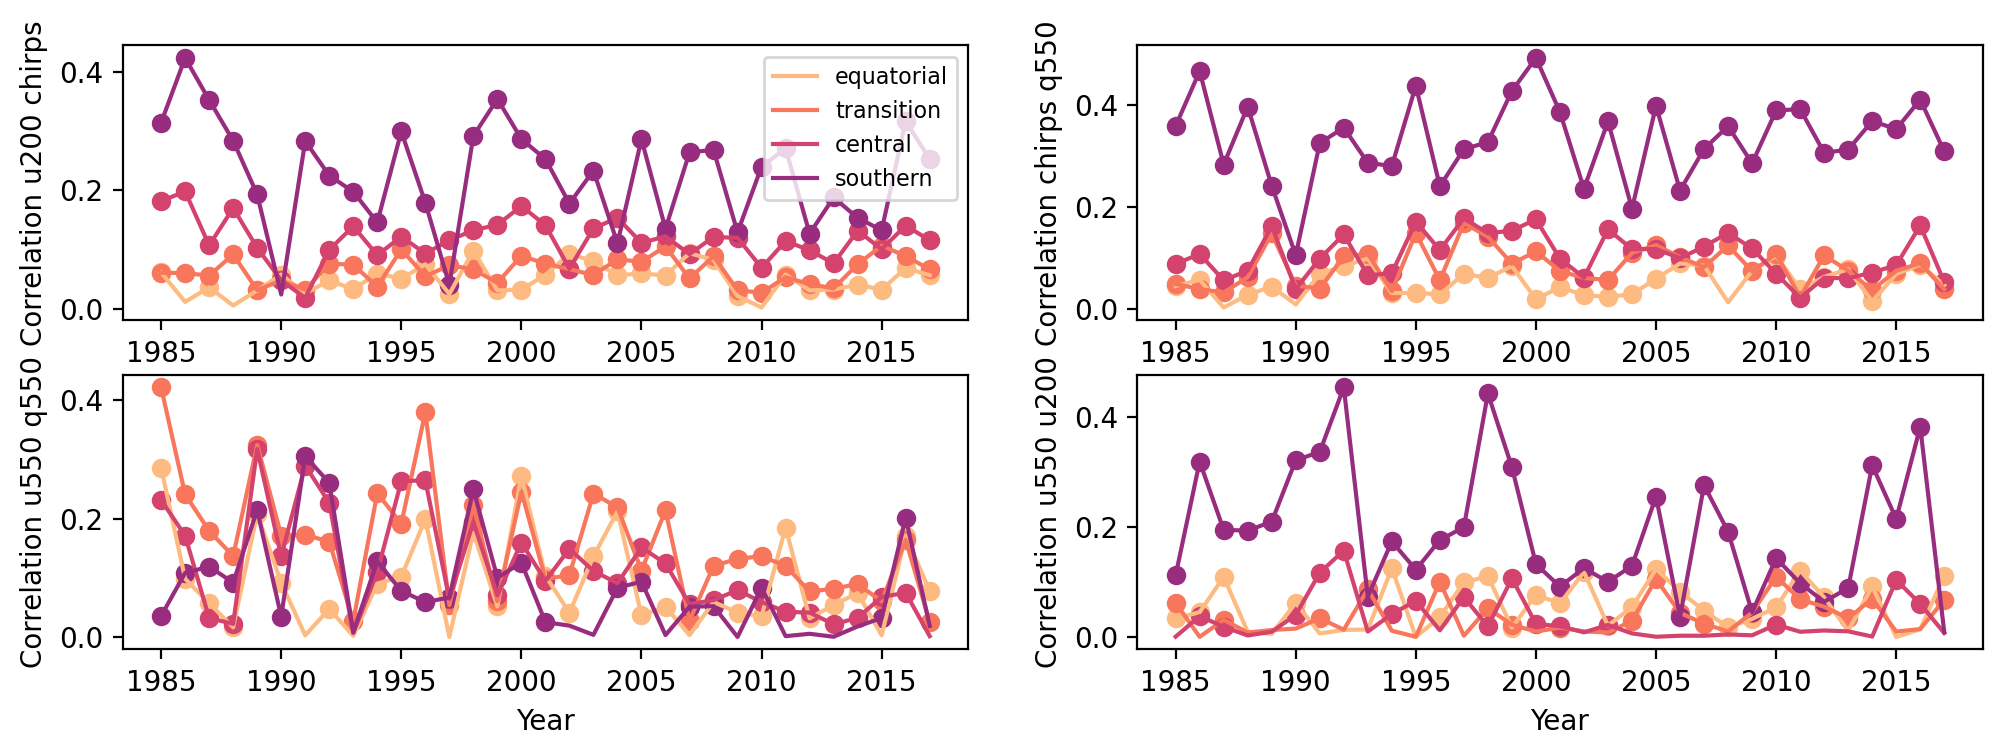

In [49]:
###chirps uwind correlation for every year

f = plt.figure(figsize=(12,4), dpi=200)
#ax = f.add_subplot(2,2,ids+1)
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)
for ids, r in enumerate(regions.keys()):
    
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    chirps_region = cau200.sel(latitude=slice(alls[0][0], alls[0][1]), time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    
    era_region_gr = u550ca['u550'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((u550ca['time.dayofyear']>=doys_s) | (u550ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    grid_region = q550ca['q550'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((q550ca['time.dayofyear']>=doys_s) | (q550ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    
    era_region_v5 = v550ca['v'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((v550ca['time.dayofyear']>=doys_s) | (v550ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))
    era_region_v = v850ca['v850'].sel(latitude=slice(alls[0][0], alls[0][1]), time =((v850ca['time.dayofyear']>=doys_s) | (v850ca['time.dayofyear']<=doys_e))).where((topo_on_g>2000))

    
    
    xxch = chirps_region.mean(['latitude', 'longitude'])#.groupby(chirps_region['time.year']).mean().load().rolling(year=5, min_periods=5, center=True).mean()
    xxera = era_region.mean(['latitude', 'longitude'])#.groupby(era_region['time.year']).mean().load().rolling(year=5, min_periods=5, center=True).mean()
    xxgrid = grid_region.mean(['latitude', 'longitude'])#.groupby(grid_region['time.year']).mean().load().rolling(year=5, min_periods=5, center=True).mean()
    xxu5 = era_region_gr.mean(['latitude', 'longitude'])
    xxv5 = era_region_v5.mean(['latitude', 'longitude'])
    xxv = era_region_v.mean(['latitude', 'longitude'])
    
    print('Entering first binning')
    dic = binning_loop(xxch, xxera)
    
    years = np.unique(chirps_region['time.year'])
    valposw = np.array(dic['pval'])<0.05
    xvalw  = (years[0:-1])[valposw]
    yvalw = np.array(dic['corr'])[valposw]
    
    ax.plot(years[0:-1], dic['corr'], label=r, color=colord[ids])
    ax.scatter(xvalw, yvalw, marker='o',  color=colord[ids])


    ax.set_xlabel('Year')
    ax.set_ylabel('Correlation u200 chirps')

    ###########################################
    print('Entering second binning')
    dic = binning_loop(xxch, xxgrid)
    
    years = np.unique(chirps_region['time.year'])
    valposw = np.array(dic['pval'])<0.05
    xvalw  = (years[0:-1])[valposw]
    yvalw = np.array(dic['corr'])[valposw]
    
    ax2.plot(years[0:-1], dic['corr'], label=r,  color=colord[ids])
    ax2.scatter(xvalw, yvalw, marker='o', color=colord[ids])


    ax2.set_xlabel('Year')
    ax2.set_ylabel('Correlation chirps q550')
    
    ###########################################
    print('Entering second binning')
    dic = binning_loop(xxu5, xxgrid)
    
    years = np.unique(chirps_region['time.year'])
    valposw = np.array(dic['pval'])<0.05
    xvalw  = (years[0:-1])[valposw]
    yvalw = np.array(dic['corr'])[valposw]
    
    ax3.plot(years[0:-1], dic['corr'], label=r,  color=colord[ids])
    ax3.scatter(xvalw, yvalw, marker='o', color=colord[ids])


    ax3.set_xlabel('Year')
    ax3.set_ylabel('Correlation u550 q550')
    
        ###########################################
    print('Entering second binning')
    dic = binning_loop(xxera, xxu5)
    
    years = np.unique(chirps_region['time.year'])
    valposw = np.array(dic['pval'])<0.05
    xvalw  = (years[0:-1])[valposw]
    yvalw = np.array(dic['corr'])[valposw]
    
    ax4.plot(years[0:-1], dic['corr'], label=r,  color=colord[ids])
    ax4.scatter(xvalw, yvalw, marker='o', color=colord[ids])


    ax4.set_xlabel('Year')
    ax4.set_ylabel('Correlation u550 u200')

    
ax.legend(fontsize=8)
#ax2.legend(fontsize=8)
#ax2.set_ylim(-50,-25)
#ax3.legend()

In [50]:
def corr(a, b, bsingle=None, c_box=None):
    ds = xr.Dataset()
    ds['pval'] = a.copy(deep=True).sum('time') * np.nan
    ds['r'] = a.copy(deep=True).sum('time') * np.nan
    ds['slope'] = a.copy(deep=True).sum('time') * np.nan

    corr_box = c_box

    if bsingle:
        bb = b
    else:
        bb = b.sel(latitude=slice(corr_box[2], corr_box[3]), longitude=slice(corr_box[0], corr_box[1])).mean(dim=['latitude', 'longitude'])

    for lat in a.latitude.values:
        for lon in a.longitude.values:
            aa = a.sel(latitude=lat, longitude=lon)
            if bsingle:
                #r, p = stats.pearsonr(aa.values, bb)

                #pf = np.polyfit(aa.values, bb, 1)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb)
            else:
                # r, p = stats.pearsonr(aa.values, bb.values)
                # pf = np.polyfit(aa.values, bb.values, 1)
                pf, intercept, r, p, std_err = stats.linregress(aa.values, bb.values)


            slope = pf#[0]

            if (np.nansum(aa.values == 0) >= 10):
                p = np.nan
                r = np.nan

            ds['r'].loc[{'latitude': lat, 'longitude': lon}] = r
            ds['pval'].loc[{'latitude': lat, 'longitude': lon}] = p
            ds['slope'].loc[{'latitude': lat, 'longitude': lon}] = slope
            #ds['intercept'].loc[{'latitude': lat, 'longitude': lon}] = intercept

    return ds

In [51]:
ploops = [(gts,1984, 2000), (gts,2001,2018), (ets,1984,2000), (ets,2001,2019)]
outloops = []

NameError: name 'gts' is not defined

In [ ]:
for pl in ploops:
    test = corr(sst_season.isel(time=(sst_season['time.year']>=pl[1]) & (sst_season['time.year']<=pl[2])).load(), pl[0][(pl[0].index.year>=pl[1])&(pl[0].index.year<=pl[2])], bsingle=True)
    print('Did', pl[1])
    outloops.append(test)

Doing equatorial
Starting correlation
Finished correlation


/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing transition
Starting correlation
Finished correlation


/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing central
Starting correlation
Finished correlation


/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Doing southern
Starting correlation
Finished correlation


/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


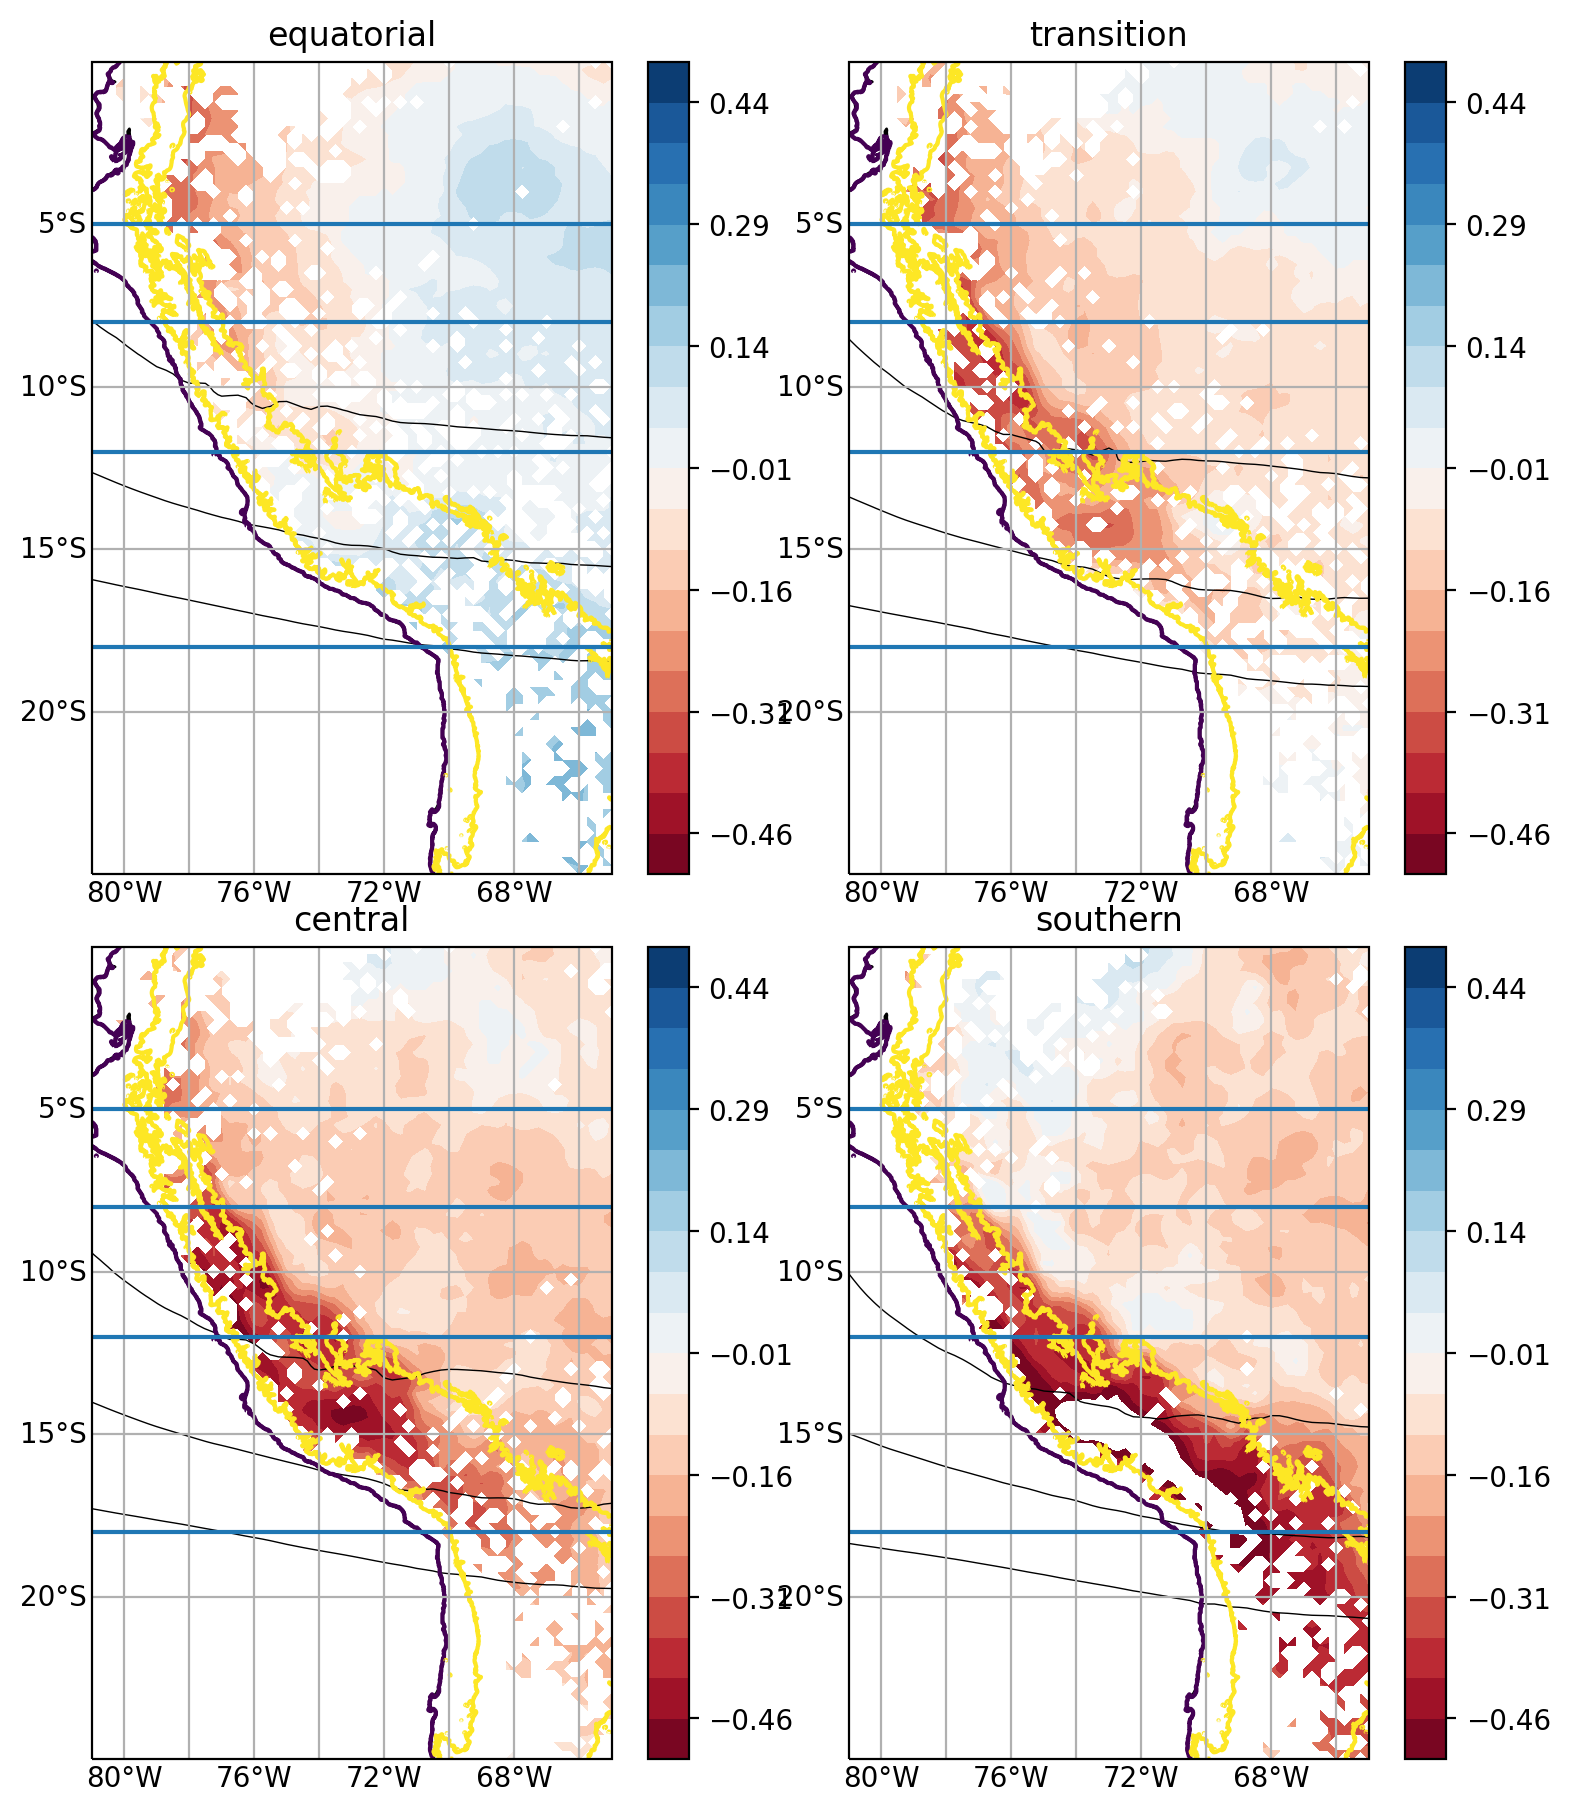

In [114]:
###chirps uwind correlation for every year

f = plt.figure(figsize=(8,9), dpi=200)

for ids, r in enumerate(regions.keys()):
    ax = f.add_subplot(2,2,ids+1, projection=ccrs.PlateCarree())
    print('Doing', r)
    alls = regions[r]
    doys_s = np.round(alls[1][0])
    doys_e = np.round(alls[1][1])
    era_region = u200ca['u'].sel(time =((u200ca['time.dayofyear']>=doys_s) | (u200ca['time.dayofyear']<=doys_e)))
    chirps_region = cau200.sel(time =((cau200['time.dayofyear']>=doys_s) | (cau200['time.dayofyear']<=doys_e))).load().rolling(time=5, min_periods=1, center='True').mean()
    
    era_region_gr = u550ca['u550'].sel(time =((u550ca['time.dayofyear']>=doys_s) | (u550ca['time.dayofyear']<=doys_e)))
    grid_region = q550ca['q550'].sel(time =((q550ca['time.dayofyear']>=doys_s) | (q550ca['time.dayofyear']<=doys_e)))
    era_region_v5 = v550ca['v'].sel(time =((v550ca['time.dayofyear']>=doys_s) | (v550ca['time.dayofyear']<=doys_e)))
    era_region_v = v850ca['v'].sel(time =((v850ca['time.dayofyear']>=doys_s) | (v850ca['time.dayofyear']<=doys_e)))

    xxch = chirps_region.sel(latitude=slice(alls[0][0], alls[0][1])).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
    xxu = era_region.sel(latitude=slice(alls[0][0], alls[0][1])).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
    xxq = grid_region.sel(latitude=slice(alls[0][0], alls[0][1])).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
    xxu550 = era_region_gr.sel(latitude=slice(alls[0][0], alls[0][1])).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
    xxv5 = era_region_v5.sel(latitude=slice(alls[0][0], alls[0][1])).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
    xxv = era_region_v.sel(latitude=slice(alls[0][0], alls[0][1])).where((topo_on_g>2000)).mean(['latitude', 'longitude'])
                         

    print('Starting correlation')
    dat = corr(chirps_region, xxu.values, bsingle=True)
    print('Finished correlation')

    ax.coastlines()
        # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    dats = dat['r'].copy(deep=True)
    dats.values[dat['pval']>0.05] = 0

    tbox = [-50,-25,0,10]
    #ax.add_patch(mpatches.Rectangle(xy=[tbox[0], tbox[2]], width=tbox[1]-tbox[0], height=tbox[3]-tbox[2], facecolor='blue', alpha=0.2, transform=ccrs.PlateCarree()))
    plt.contourf(era_region.longitude, era_region.latitude, dats, levels=np.arange(-0.51,0.51,0.05), cmap='RdBu', transform=ccrs.PlateCarree())
    plt.colorbar()
    plt.contour(era_region.longitude, era_region.latitude, era_region.mean('time'), colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), levels=[-10,-5,0,5,10])
    plt.contour(topo.lon, topo.lat, topo, levels=[0,2000])
    ax.axhline(-18)
    ax.axhline(-12)
    ax.axhline(-8)
    ax.axhline(-5)
    plt.title(r)
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/correlations/u200Spatial_vs_chirpsSpatial.jpg')